# miRNA Expression Across Projects

The expression of a single miRNA or set of miRNAs across TCGA projects can be pulled out.

In [ ]:
import pandas as pd

def fetch_mirna_reads(mir_id_list, mir_name_list, mir_summary_dir, out_file):
    """
        mir_id_list: list of miRBase IDs
        mir_name_list: list of miRNA names
        mir_summary_dir: directory with miRNA summary files
    """
    projects = ['CESC', 'UCEC', 'OV', 'THCA', 'STAD', 'CHOL', 'UCS', 'DLBC', 'UVM', 'MESO', 'ACC', 'KICH', 'THYM', 
                'TGCT', 'READ','BRCA', 'GBM', 'LUAD', 'KIRC', 'HNSC', 'LGG', 'LUSC', 'PRAD', 'SKCM', 'COAD', 'BLCA', 
                'LIHC', 'KIRP', 'SARC', 'LAML', 'ESCA', 'PAAD', 'PCPG']

    out_dict = {"TCGA Project":[], "miRNA": [], "Sample": [], "Case ID": [], "Read Counts": []}
    for proj in projects:
        df = pd.read_csv("{}/{} miRNA-seq RPM Reads.csv".format(mir_summary_dir, proj), 
                         header=0, index_col=0)
        num_samp = len(df.columns)
        out_dict["TCGA Project"] += [proj]*2*num_samp
        
        for i in range(len(mir_id_list)):
            out_dict["miRNA"] += [mir_name_list[i]]*num_samp
            mir_ser = df.loc[mir_id_list[i]]
            out_dict["Read Counts"] += mir_ser.tolist()
            out_dict["Sample"] += mir_ser.index.tolist()
            out_dict["Case ID"] += [x.split("_")[0] for x in mir_ser.index.tolist()]

    df_out = pd.DataFrame(data=out_dict)
    df_out.to_csv(out_file, index_label=False)

# miRNA Plot

The expression of the selected miRNA across different TCGA projects can then be plotted.

In [1]:
%matplotlib inline

import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def make_mir_plot(in_file, out_file, sort_mir=False, figsize=False, ignore=False, 
                  select_proj=False):
    """
        in_file: file with miRNA read counts with the columns "TCGA Project", 
            "miRNA", "Sample" and "Read Counts"
        out_file: file to save the plot to 
        sort_mir (optional): sort the TCGA projects from highest to lowest read 
            counts based on the read counts for passed in miRNA
        figsize (optional): tuple with (width, height) of image in images
        ignore (optional): list of TCGA projects to not include in the plot
        select_proj (optional): list of TCGA projects to include in plot
    """
    
    df = pd.read_csv(in_file, header=0)
    
    # look only at primary tumor samples
    df_primary = df[(df["Sample"].str.contains("_01")) | (df["Sample"].str.contains("_03"))]
    # exclude TCGA project 
    if ignore != False:
        df_primary = df_primary[~df_primary["TCGA Project"].isin(ignore)]
    # include only specific projects
    if select_proj != False:
        df_primary = df_primary[df_primary["TCGA Project"].isin(select_proj)]
    
    df_primary[r"log$_2$(Read Counts)"] = df_primary["Read Counts"].apply(lambda y: 0 if y==0 else math.log(y,2))
    
    if sort_mir != False:
        # sort by the mean value of sort_mir in each project
        df_mean = df_primary.groupby(["TCGA Project", "miRNA"]).mean()
        df_mean.sort_values(r"log$_2$(Read Counts)", inplace=True, ascending=False)
        proj_order_set = df_mean[df_mean.index.get_level_values("miRNA") == sort_mir].index.tolist()
        proj_order = [x[0] for x in proj_order_set]
    
    sns.set(color_codes=True, style="ticks")

    if not figsize:
        fig, ax = plt.subplots(1,1)
    else:
        fig, ax = plt.subplots(1,1, figsize=figsize)
    
    if sort_mir != False:
        ax = sns.boxplot(x="miRNA", y=r"log$_2$(Read Counts)", hue="TCGA Project", data=df_primary, ax=ax, 
                         hue_order=proj_order, fliersize=3)
    else:
        ax = sns.boxplot(x="miRNA", y=r"log$_2$(Read Counts)", hue="TCGA Project", data=df_primary, ax=ax, fliersize=3)
    sns.despine()
    ax.set_xlabel("")
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc=6, ncol=2, handletextpad=0.2, columnspacing=0.5)

    fig.savefig(out_file, bbox_inches="tight", dpi=400)

## Examples

As an examples, we can look at miR-151a-3p and -5p expression across projects.

c:\python27\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


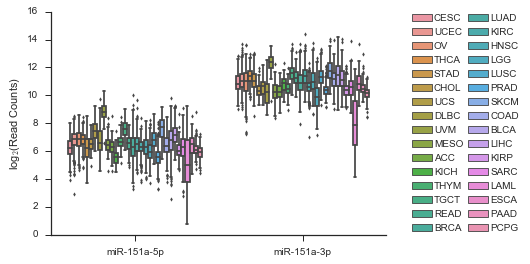

In [2]:
make_mir_plot("miR-151a Example/Pan Cancer miR-151a-5p and -3p Expression (Tidy).csv", 
              "miR-151a Example/TCGA miR-151a Expression.png")

Below, the projects are sort based on the average miR-151a-5p values.

c:\python27\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


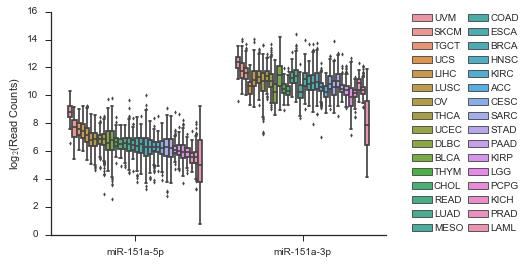

In [3]:
make_mir_plot("miR-151a Example/Pan Cancer miR-151a-5p and -3p Expression (Tidy).csv", 
              "miR-151a Example/TCGA miR-151a Expression (Sorted).png", sort_mir="miR-151a-5p")

If we wanted to exclude kidney cancers, we can remove the KIRC, KIRP, and KICH projects.

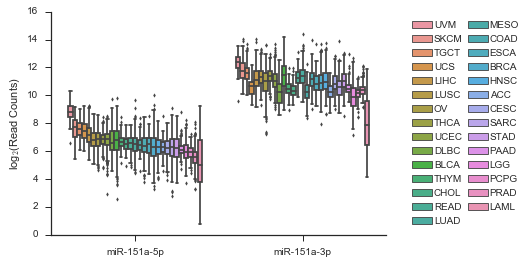

In [4]:
make_mir_plot("miR-151a Example/Pan Cancer miR-151a-5p and -3p Expression (Tidy).csv", 
              "miR-151a Example/TCGA miR-151a Expression (Sorted; wo kidney).png", sort_mir="miR-151a-5p", 
              ignore=["KIRC", "KIRP", "KICH"])

If we then wanted to only look at kidney cancers, we can select only those projects.

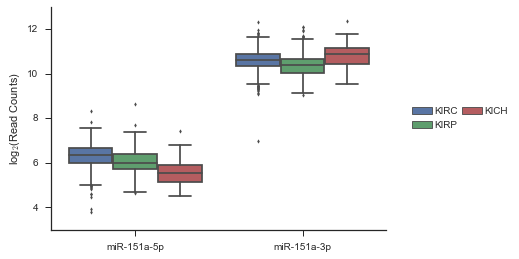

In [5]:
make_mir_plot("miR-151a Example/Pan Cancer miR-151a-5p and -3p Expression (Tidy).csv", 
              "miR-151a Example/TCGA miR-151a Expression (Sorted; only kidney).png", sort_mir="miR-151a-5p", 
              select_proj=["KIRC", "KIRP", "KICH"])